In [1]:
import numpy as np
import pandas as pd
import scipy
import scipy.linalg.interpolative as sli
from matplotlib import pyplot as plt
from tqdm.notebook import tqdm, trange
from time import perf_counter

## Define low-rank approximations

### Singular Value Decomposition

In [2]:
def svd(A, k):
    """Computes the optimal deterministic rank-k approximation of the SVD of the input matrix."""
    U, sigma, Vh = np.linalg.svd(A, full_matrices=False)
    Sigma = np.diag(sigma[:k])
    return U[:,:k] @ Sigma @ Vh[:k], None

### Orthogonal Projection Interpolative Decompositions

In [3]:
def opid(A, k, col_pivoted=True):
    """Computes a deterministic rank-k approximation of the OPID of the input matrix."""
    
    # if A is (m,n) with m <= n, then Q is (m,m) and R is (m,n)
    
    temp = scipy.linalg.qr(A, pivoting=col_pivoted, mode='economic', check_finite=False)  # returns Q, R, P
    Q = temp[0]
    
    if col_pivoted:
        P = temp[2][:k]
    else:
        P = np.arange(k)
        
    Q_k = Q[:,:k]
    approx = Q_k @ Q_k.T @ A
    
    _ = np.linalg.lstsq(approx[:,:k], approx, rcond=None)  # compute actual decomposition for accurate time measurement
    
    return approx, P

In [4]:
def opid_pivot(A, k):
    return opid(A, k, col_pivoted=True)

def opid_nopivot(A, k):
    return opid(A, k, col_pivoted=False)

In [5]:
def random_opid(A, k, oversampling=10, col_pivoted=True):
    """Calculates a randomized rank-k approximation of the OPID of the input matrix."""
    
    if oversampling < 0:
        raise ValueError('Oversampling parameter cannot be negative.')
        
    p = k + oversampling
    if p > A.shape[1]:
        raise ValueError('Oversampling parameter is too large.')
    
    cols = np.random.choice(A.shape[1], replace=False, size=p)

    AS = A[:,cols]
    
    temp = scipy.linalg.qr(AS, pivoting=col_pivoted, mode='economic', check_finite=False)
    Q = temp[0]
    
    if col_pivoted:
        P = temp[2][:p]
    else:
        P = np.arange(p)

    Q_k = Q[:,:k]  # removes the p-k oversampled columns
    approx = Q_k @ Q_k.T @ A
    
    _ = np.linalg.lstsq(approx[:,cols[P][:k]], approx, rcond=None)  # compute actual decomposition for accurate time measurement
    
    return approx, cols[P][:k]

In [6]:
def ropid_op(A, k):
    return random_opid(A, k, oversampling=10, col_pivoted=True)

def ropid_o(A, k):
    return random_opid(A, k, oversampling=10, col_pivoted=False)

def ropid_p(A, k):
    return random_opid(A, k, oversampling=0, col_pivoted=True)

def ropid_none(A, k):
    return random_opid(A, k, oversampling=0, col_pivoted=False)

### SciPy Interpolative Decompositions

In [7]:
def scipy_id(A, k):
    idx, proj = sli.interp_decomp(A, k, rand=False)
    B = sli.reconstruct_skel_matrix(A, k, idx)
    C = sli.reconstruct_matrix_from_id(B, idx, proj)
    return C, idx[:k]

def scipy_random_id(A, k):
    idx, proj = sli.interp_decomp(A, k, rand=True)
    B = sli.reconstruct_skel_matrix(A, k, idx)
    C = sli.reconstruct_matrix_from_id(B, idx, proj)
    return C, idx[:k]

## Read data

In [8]:
mnist = pd.read_csv('../datasets/mnist/train.csv')

data = mnist[mnist.columns[1:]].values / 255
data = data[:5000]

Transpose the data matrix if necessary --- we want the matrix to be 'wide' not 'tall'.

In [9]:
if data.shape[0] > data.shape[1]:
    data = data.T

In [10]:
data.shape

(784, 5000)

In [11]:
def display_img(A, n):
    choices = np.random.choice(A.shape[1], replace=False, size=n)
    plt.imshow(A[:,choices].reshape(28,28,n).transpose(0,2,1).reshape(28,n*28))

In [12]:
# display_img(data, 5)

In [13]:
data_norm = np.linalg.norm(data)

In [14]:
def calculate_error(A):
    return np.linalg.norm(data - A) / data_norm

In [15]:
def stats(A):
    res = np.empty(7)
    
    res[0] = np.quantile(A, 0.25)
    res[1] = np.median(A)
    res[2] = np.quantile(A, 0.75)
    res[3] = np.mean(A)
    res[4] = np.std(A)
    res[5] = np.min(A)
    res[6] = np.max(A)
    
    return np.copy(res)

In [16]:
k_domain = np.arange(10, 490, step=40)
k_len = k_domain.shape[0]

### deterministic methods

In [17]:
DET_ID_ALGS = [scipy_id, opid_pivot, opid_nopivot]
DET_ALGS = [svd] + DET_ID_ALGS
num_det_algs = len(DET_ALGS)

DET_ERRORS = np.empty((num_det_algs, k_len))
DET_TIMES = np.empty((num_det_algs, k_len))
DET_COLUMNS_PRESERVED = np.empty((num_det_algs-1, k_len))
DET_ENTRIES_BOUNDED = np.empty((num_det_algs-1, k_len))

for i, k in enumerate(tqdm(k_domain)):
    for h, alg in enumerate(tqdm(DET_ALGS, leave=False)):
        start = perf_counter()
        approx, cols = alg(data, k)
        DET_TIMES[h,i] = perf_counter() - start
        
        DET_ERRORS[h,i] = calculate_error(approx)
        
        if alg == svd:
            continue
        
        C = data[:,cols]
        DET_COLUMNS_PRESERVED[h-1,i] = int(np.allclose(C, approx[:,cols]))

        ls_res = np.linalg.lstsq(C, approx, rcond=None)
        Z = ls_res[0]
        DET_ENTRIES_BOUNDED[h-1,i] = np.max(np.abs(Z))

### randomized methods

In [18]:
RAND_ALGS = [scipy_random_id, ropid_op, ropid_o, ropid_p, ropid_none]
num_rand_algs = len(RAND_ALGS)

RAND_ERRORS = np.empty((num_rand_algs, 7, k_len))
RAND_TIMES = np.empty((num_rand_algs, 7, k_len))
RAND_COLUMNS_PRESERVED = np.empty((num_rand_algs, 7, k_len))
RAND_ENTRIES_BOUNDED = np.empty((num_rand_algs, 7, k_len))

iterations = 1 #3 #10

for i, k in enumerate(tqdm(k_domain)):
    errors = np.empty((num_rand_algs, iterations))
    times = np.empty((num_rand_algs, iterations))
    columns_preserved = np.empty((num_rand_algs, iterations))
    entries_bounded = np.empty((num_rand_algs, iterations))

    for j in trange(iterations, leave=False):
        for h, alg in enumerate(tqdm(RAND_ALGS, leave=False)):
            start = perf_counter()
            approx, cols = alg(data, k)
            times[h,j] = perf_counter() - start
            
            errors[h,j] = calculate_error(approx)
            
            C = data[:,cols]
            columns_preserved[h,j] = int(np.allclose(C, approx[:,cols]))
            
            ls_res = np.linalg.lstsq(C, approx, rcond=None)
            Z = ls_res[0]
            entries_bounded[h,j] = np.max(np.abs(Z))
        
    for h in range(num_rand_algs):
        RAND_ERRORS[h,:,i] = stats(errors[h])
        RAND_TIMES[h,:,i] = stats(times[h])
        RAND_COLUMNS_PRESERVED[h,:,i] = stats(columns_preserved[h])
        RAND_ENTRIES_BOUNDED[h,:,i] = stats(entries_bounded[h])

## Display results

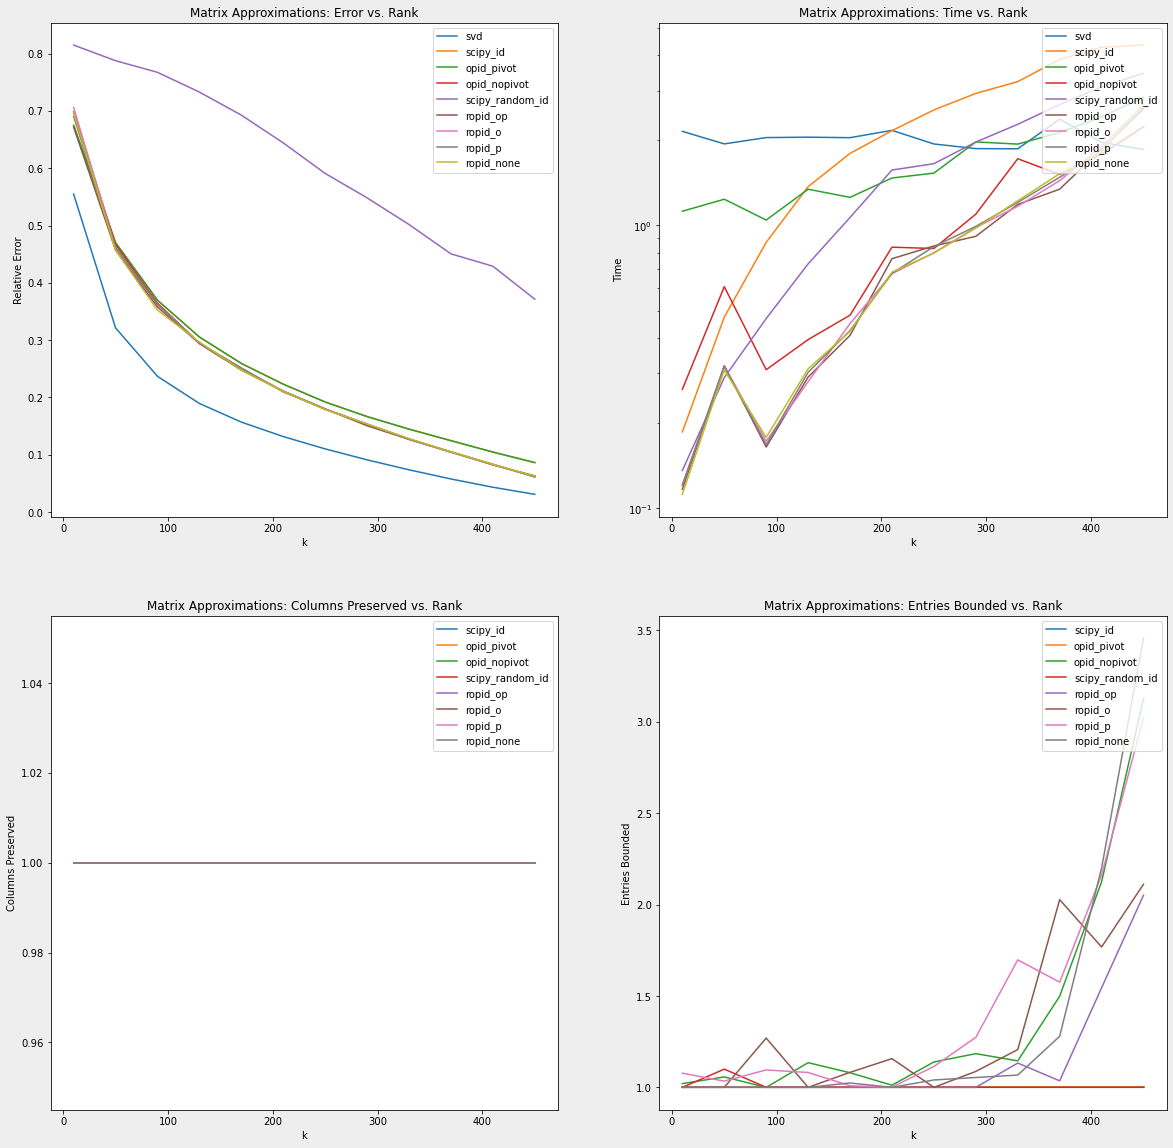

In [19]:
fig, ax = plt.subplots(2,2, figsize=(20,20))
fig.set_facecolor('#EEE')


# ERROR GRAPH
for h, alg in enumerate(DET_ALGS):
    ax[0,0].plot(k_domain, DET_ERRORS[h], label=alg.__name__)
for h, alg in enumerate(RAND_ALGS):
    ax[0,0].plot(k_domain, RAND_ERRORS[h,3], label=alg.__name__)

ax[0,0].set_xlabel('k')
ax[0,0].set_ylabel('Relative Error')
# ax[0,0].set_yscale('log')
ax[0,0].legend(loc='upper right')
ax[0,0].set_title('Matrix Approximations: Error vs. Rank')


# TIME GRAPH
for h, alg in enumerate(DET_ALGS):
    ax[0,1].plot(k_domain, DET_TIMES[h], label=alg.__name__)
for h, alg in enumerate(RAND_ALGS):
    ax[0,1].plot(k_domain, RAND_TIMES[h,3], label=alg.__name__)

ax[0,1].set_xlabel('k')
ax[0,1].set_ylabel('Time')
ax[0,1].set_yscale('log')
ax[0,1].legend(loc='upper right')
ax[0,1].set_title('Matrix Approximations: Time vs. Rank')


# COLUMNS PRESERVED
for h, alg in enumerate(DET_ID_ALGS):
    ax[1,0].plot(k_domain, DET_COLUMNS_PRESERVED[h], label=alg.__name__)
for h, alg in enumerate(RAND_ALGS):
    ax[1,0].plot(k_domain, RAND_COLUMNS_PRESERVED[h,3], label=alg.__name__)

ax[1,0].set_xlabel('k')
ax[1,0].set_ylabel('Columns Preserved')
# ax[1,0].set_yscale('log')
ax[1,0].legend(loc='upper right')
ax[1,0].set_title('Matrix Approximations: Columns Preserved vs. Rank')


# ENTRIES BOUNDED
for h, alg in enumerate(DET_ID_ALGS):
    ax[1,1].plot(k_domain, DET_ENTRIES_BOUNDED[h], label=alg.__name__)
for h, alg in enumerate(RAND_ALGS):
    ax[1,1].plot(k_domain, RAND_ENTRIES_BOUNDED[h,3], label=alg.__name__)

ax[1,1].set_xlabel('k')
ax[1,1].set_ylabel('Entries Bounded')
# ax[1,1].set_yscale('log')
ax[1,1].legend(loc='upper right')
ax[1,1].set_title('Matrix Approximations: Entries Bounded vs. Rank');

In [20]:
for h, alg in enumerate(DET_ID_ALGS):
    print(DET_COLUMNS_PRESERVED[h], alg.__name__)
for h, alg in enumerate(RAND_ALGS):
    print(RAND_COLUMNS_PRESERVED[h,3], alg.__name__)

[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.] scipy_id
[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.] opid_pivot
[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.] opid_nopivot
[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.] scipy_random_id
[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.] ropid_op
[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.] ropid_o
[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.] ropid_p
[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.] ropid_none
